In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /content/daily-min-temperatures.csv

--2020-09-13 12:53:44--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/content/daily-min-temperatures.csv’

/content/daily-min- 100%[===================>]  66.33K  --.-KB/s    in 0.009s  

2020-09-13 12:53:45 (7.03 MB/s) - ‘/content/daily-min-temperatures.csv’ saved [67921/67921]



In [3]:
import pandas as pd

df = pd.read_csv('/content/daily-min-temperatures.csv')
df.head()

#This is a pandas dataframe, so the index will be appended to the left. 
#For the actual CSV file, there are only 2 columns

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [4]:
import csv

time_step = []
temp = []

with open('/content/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile,delimiter=',')
  #Skip the first line of the csv (Because it's the axis names, which is not part of the data)
  next(reader)
  step = 0
  for row in reader:
    temp.append(float(row[1]))
    time_step.append(step)
    step += 1

series = np.array(temp)
time = np.array(time_step)

In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

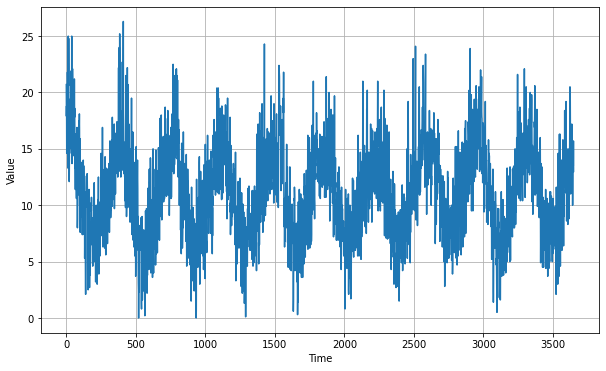

In [6]:
plt.figure(figsize=(10,6))
plot_series(time,series)

In [7]:
split_time = 2500

#This is the time (From 0-2500)
time_train = time[:split_time]
#This is the value (of temperature) at the time (0-2500)
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

In [8]:
def windowed_dataset(series,window_size,batch_size,shuffle_buffer):
  #Expand from 2D to the expected 3D
  series = tf.expand_dims(series,axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1,shift=1,drop_remainder=True)
  ds = ds.flat_map(lambda w:w.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer)
  #Split into x and y (label)
  ds = ds.map(lambda w: (w[:-1],w[1:]))
  #Prefetch for faster memory process
  return ds.batch(batch_size).prefetch(1)

In [9]:
#Destory the current graph, so previous models wont be used
tf.keras.backend.clear_session()

window_size = 64
batch_size = 256
shuffle_buffer_size = 1000

#Create a windowed dataset from the training series. Need this in order to feed to the model for training
train_set = windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)

In [10]:
print(train_set)
print(np.shape(x_train))

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)


In [ ]:
model = tf.keras.models.Sequential([
                                    #Padding ='causal' means that you zero pad the front values, so you can predict the values of early time steps 
                                    tf.keras.layers.Conv1D(filters=32,kernel_size=5,strides=1,padding='causal',activation='relu',input_shape=[None,1]),
                                    tf.keras.layers.LSTM(64,return_sequences=True),
                                    tf.keras.layers.Dense(30, activation="relu"),
                                    tf.keras.layers.Dense(10, activation="relu"),
                                    tf.keras.layers.Dense(1),
                                    #Lambda layer allows you to do arbitiary functions (Format data,etc..)
                                    tf.keras.layers.Lambda(lambda x:x*400)
])

#This is a callback that changes the learning rate according to the current epoch. 
#This allows for one to see the best learning rate to use
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)

optimizer = tf.keras.optimizers.SGD(lr=1e-8,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 1s 146ms/step - loss: 110.7168 - mae: 111.2168 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 1s 143ms/step - loss: 107.2609 - mae: 107.7609 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 1s 145ms/step - loss: 101.9575 - mae: 102.4574 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 1s 140ms/step - loss: 95.5552 - mae: 96.0552 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 1s 140ms/step - loss: 88.4258 - mae: 88.9257 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 1s 143ms/step - loss: 80.9911 - mae: 81.4911 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 1s 140ms/step - loss: 74.0672 - mae: 74.5672 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 1s 144ms/step - loss: 68.3171 - mae: 68.8171 - lr: 2.2387e-08
Epoch 9/100
10/10 [==============================] - 1s 143ms/step - loss:

(1e-08, 0.0001, 0.0, 60.0)

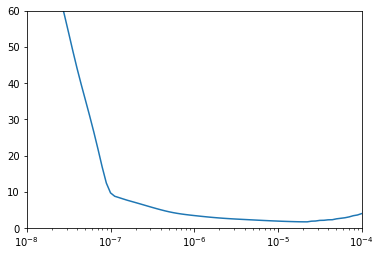

In [ ]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-8,1e-4,0,60])

In [ ]:
#The graph shows that lr= 1e-5 is the best lr (Gives the lowest loss)
#Repeat the training process with the optimum lr

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 3s 118ms/step - loss: 9.9820 - mae: 10.4700
Epoch 2/150
25/25 [==============================] - 3s 119ms/step - loss: 2.5294 - mae: 2.9922
Epoch 3/150
25/25 [==============================] - 3s 118ms/step - loss: 1.9501 - mae: 2.4046
Epoch 4/150
25/25 [==============================] - 3s 118ms/step - loss: 1.8618 - mae: 2.3151
Epoch 5/150
25/25 [==============================] - 3s 118ms/step - loss: 1.8215 - mae: 2.2733
Epoch 6/150
25/25 [==============================] - 3s 118ms/step - loss: 1.7908 - mae: 2.2418
Epoch 7/150
25/25 [==============================] - 3s 120ms/step - loss: 1.7686 - mae: 2.2186
Epoch 8/150
25/25 [==============================] - 3s 121ms/step - loss: 1.7413 - mae: 2.1906
Epoch 9/150
25/25 [==============================] - 3s 118ms/step - loss: 1.7193 - mae: 2.1681
Epoch 10/150
25/25 [==============================] - 3s 118ms/step - loss: 1.7000 - mae: 2.1483
Epoch 11/150
25/25 [==================

In [ ]:
def model_predict(model,series,window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size,shift=1,drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [ ]:
#Predict the values given the whole series (train and validation series included)
#series[:,np.newaxis] creates a new axis at the last dimension index
#Must format the data to the type that the model accepted during training
pred = model_predict(model,series[:,np.newaxis],window_size)
#Return only the predicted values for the validation series
#This predicted value is derived from the previous window_size values in the series. 
pred = pred[split_time-window_size:-1,-1,0]

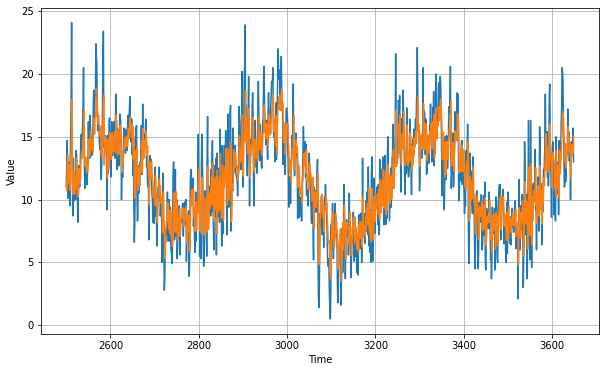

In [ ]:
plt.figure(figsize=(10, 6))
# plot the actual graph for the valid
plot_series(time_valid, x_valid)
# plot the predicted graph for the valid
plot_series(time_valid, pred)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid,pred).numpy()

1.7797481